# **Analysis of Big data**


# Setting up PySpark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["SPARK_HOME"] = "/content/spark-3.5.5-bin-hadoop3"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import isnull, when, count, isnan, col, lit, udf, dayofweek, date_format, month, countDistinct
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.stat import ChiSquareTest, Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, UnivariateFeatureSelector
from pyspark.sql.functions import col, when
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Loading the Data

https://www.kaggle.com/datasets/joebeachcapital/coronavirus-covid-19-cases-daily-updates?select=Coronavirus_cases_daily_update.csv

In [5]:
import kagglehub

path = kagglehub.dataset_download("joebeachcapital/coronavirus-covid-19-cases-daily-updates")

print("Path to dataset files:", path)

100%|██████████| 10.4M/10.4M [00:00<00:00, 55.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/joebeachcapital/coronavirus-covid-19-cases-daily-updates/versions/506


In [ ]:
print(os.listdir(path))

['README', 'Coronavirus_cases_daily_update.csv', 'owid_covid_codebook.csv']


In [6]:
file_path = path + "/Coronavirus_cases_daily_update.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show first few rows
df.show(5)

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

In [7]:
display(df)

DataFrame[iso_code: string, continent: string, location: string, date: date, total_cases: double, new_cases: double, new_cases_smoothed: double, total_deaths: double, new_deaths: double, new_deaths_smoothed: double, total_cases_per_million: double, new_cases_per_million: double, new_cases_smoothed_per_million: double, total_deaths_per_million: double, new_deaths_per_million: double, new_deaths_smoothed_per_million: double, reproduction_rate: double, icu_patients: double, icu_patients_per_million: double, hosp_patients: double, hosp_patients_per_million: double, weekly_icu_admissions: double, weekly_icu_admissions_per_million: double, weekly_hosp_admissions: double, weekly_hosp_admissions_per_million: double, total_tests: double, new_tests: double, total_tests_per_thousand: double, new_tests_per_thousand: double, new_tests_smoothed: double, new_tests_smoothed_per_thousand: double, positive_rate: double, tests_per_case: double, tests_units: string, total_vaccinations: double, people_vacc

In [8]:
df.printSchema()


root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: date (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million: 

**Data Cleaning and Preprocessing**

In [9]:
df.select("location").distinct().count()

255

In [10]:
df = df.dropDuplicates()

In [12]:
from pyspark.sql.functions import col, isnan, isnull
from pyspark.sql.types import NumericType

# Separate numeric and non-numeric columns
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
non_numeric_cols = [f.name for f in df.schema.fields if not isinstance(f.dataType, NumericType)]

# Build condition: isnull for all, isnan only for numeric
conditions = [
    (isnull(col(c)) | isnan(col(c))) if c in numeric_cols else isnull(col(c))
    for c in df.columns
]

# Count rows with any missing value
missing_rows_count = df.filter(
    sum(condition.cast("int") for condition in conditions) > 0
).count()

print(f"Rows with missing values: {missing_rows_count}")



Rows with missing values: 429435


In [13]:
from pyspark.sql.functions import col, isnull, isnan, sum as spark_sum
from pyspark.sql.types import NumericType


missing_exprs = [
    spark_sum(
        (isnull(col(c)) | isnan(col(c))).cast("int") if isinstance(df.schema[c].dataType, NumericType)
        else isnull(col(c)).cast("int")
    ).alias(c)
    for c in df.columns
]


df.select(missing_exprs).show()

+--------+---------+--------+----+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------------

In [14]:
from pyspark.ml.feature import StringIndexer

# Step 1: Define the indexer
country_indexer = StringIndexer(inputCol="location", outputCol="location_index")

# Step 2: Fit and transform the DataFrame
df = country_indexer.fit(df).transform(df)

# Step 3: Now you can access the column!
df.select("location", "location_index").show(5)

+-----------+--------------+
|   location|location_index|
+-----------+--------------+
|Afghanistan|          21.0|
|Afghanistan|          21.0|
|Afghanistan|          21.0|
|Afghanistan|          21.0|
|Afghanistan|          21.0|
+-----------+--------------+
only showing top 5 rows



Converted location column to a numerical column under the name of location index for the ML model to understand it properly

In [15]:
cols_to_impute = [
    "total_cases", "new_cases", "new_cases_smoothed",
    "total_deaths", "new_deaths", "new_deaths_smoothed",
    "total_cases_per_million", "new_cases_per_million", "new_cases_smoothed_per_million",
    "total_deaths_per_million", "new_deaths_per_million", "new_deaths_smoothed_per_million",
    "reproduction_rate", "icu_patients", "icu_patients_per_million",
    "hosp_patients", "hosp_patients_per_million",
    "weekly_icu_admissions", "weekly_icu_admissions_per_million", "weekly_hosp_admissions",
    "weekly_hosp_admissions_per_million",
    "total_tests", "new_tests", "total_tests_per_thousand", "new_tests_per_thousand",
    "new_tests_smoothed", "new_tests_smoothed_per_thousand", "positive_rate", "tests_per_case", "tests_units",
    "total_vaccinations", "people_vaccinated", "people_fully_vaccinated", "total_boosters",
    "new_vaccinations", "new_vaccinations_smoothed",
    "total_vaccinations_per_hundred", "people_vaccinated_per_hundred", "people_fully_vaccinated_per_hundred",
    "total_boosters_per_hundred", "new_vaccinations_smoothed_per_million",
    "new_people_vaccinated_smoothed", "new_people_vaccinated_smoothed_per_hundred"
]


In [16]:
from pyspark.sql.functions import coalesce, lit

# Replace nulls with 0 for each column
for col_name in cols_to_impute:
    df = df.withColumn(col_name, coalesce(df[col_name], lit(0)))


 This technique indicates that no data was recorded due to lack of cases, inactivity, or non-reporting, rather than data corruption. Therefore, imputing with 0 ensures that the model treats these as zero events rather than discards them as unknowns, which helps preserve the structure and completeness of the time-series data."

In [17]:
median_impute_cols = [
    "stringency_index", "population_density", "median_age",
    "aged_65_older", "aged_70_older", "gdp_per_capita",
    "extreme_poverty", "cardiovasc_death_rate", "diabetes_prevalence",
    "female_smokers", "male_smokers", "handwashing_facilities",
    "hospital_beds_per_thousand", "life_expectancy", "human_development_index",
    "population", "excess_mortality_cumulative_absolute", "excess_mortality_cumulative",
    "excess_mortality", "excess_mortality_cumulative_per_million"
]

In [18]:
from pyspark.ml.feature import Imputer

imputer_median = Imputer(
    inputCols=median_impute_cols,
    outputCols=median_impute_cols
).setStrategy("median")

df = imputer_median.fit(df).transform(df)

The following columns were imputed using the median strategy because the data appears to be skewed — likely due to variability across countries, differing population demographics, healthcare access, and incomplete reporting during the COVID-19 pandemic. Median is more robust to outliers and missing values, making it a safer choice for skewed datasets like this one.

In [19]:
from pyspark.sql.functions import when, col

df = df.withColumn("continent", when(col("continent").isNull(), "Unknown").otherwise(col("continent")))

Missing values in the continent column were filled with 'Unknown' to avoid incorrect assumptions. Since continent is a categorical variable, imputing with the most common value could introduce bias. Using 'Unknown' preserves data integrity and allows the model to treat these cases separately.

In [20]:
from pyspark.sql.functions import col, isnull, isnan, sum as spark_sum
from pyspark.sql.types import NumericType


missing_exprs = [
    spark_sum(
        (isnull(col(c)) | isnan(col(c))).cast("int") if isinstance(df.schema[c].dataType, NumericType)
        else isnull(col(c)).cast("int")
    ).alias(c)
    for c in df.columns
]


df.select(missing_exprs).show()

+--------+---------+--------+----+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+----------------------------------------

Feature Engineering

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, when, broadcast

# Step 1: Get 90th percentile threshold for each country
thresholds = df.groupBy("location").agg(
    expr("percentile_approx(new_deaths_per_million, 0.9)").alias("risk_threshold")
)

# Step 2: Join thresholds back to original DataFrame
df = df.join(broadcast(thresholds), on="location", how="left")

# Step 3: Create the high_risk column
df = df.withColumn("high_risk", when(col("new_deaths_per_million") > col("risk_threshold"), 1).otherwise(0))


In [ ]:
df.select("high_risk").show(5)

+---------+
|high_risk|
+---------+
|        0|
|        0|
|        0|
|        0|
|        0|
+---------+
only showing top 5 rows



COVID-19 severity varies drastically across countries. Using a universal threshold to define "high-risk" days would unfairly flag smaller or low-reporting countries.
By using a country-specific 90th percentile, we define high-risk days relative to each country’s own data, allowing fair and consistent classification.

This ensures machine learning model to learn patterns that reflect localized severity, not global bias.

In [ ]:
selected_features = [
    "total_cases", "new_cases", "new_cases_smoothed",
    "total_deaths", "new_deaths", "new_deaths_smoothed",
    "reproduction_rate", "icu_patients", "icu_patients_per_million",
    "hosp_patients", "hosp_patients_per_million",
    "weekly_icu_admissions", "weekly_icu_admissions_per_million",
    "weekly_hosp_admissions", "weekly_hosp_admissions_per_million",
    "total_tests", "new_tests", "total_tests_per_thousand",
    "new_tests_per_thousand", "new_tests_smoothed", "new_tests_smoothed_per_thousand",
    "positive_rate", "tests_per_case", "total_vaccinations", "people_vaccinated",
    "people_fully_vaccinated", "total_boosters", "new_vaccinations", "new_vaccinations_smoothed",
    "total_vaccinations_per_hundred", "people_vaccinated_per_hundred",
    "people_fully_vaccinated_per_hundred", "total_boosters_per_hundred",
    "new_vaccinations_smoothed_per_million", "new_people_vaccinated_smoothed",
    "new_people_vaccinated_smoothed_per_hundred", "stringency_index", "population_density",
    "median_age", "aged_65_older", "aged_70_older", "gdp_per_capita", "extreme_poverty",
    "cardiovasc_death_rate", "diabetes_prevalence", "female_smokers", "male_smokers",
    "handwashing_facilities", "hospital_beds_per_thousand", "life_expectancy",
    "human_development_index", "population", "location_index"
]

In [ ]:
# Convert to Pandas
pandas_df = df.select(selected_features + ["high_risk"]).dropna().toPandas()

In [ ]:
!pip install -q imbalanced-learn

In [ ]:
from imblearn.combine import SMOTEENN

X = pandas_df[selected_features]
y = pandas_df["high_risk"]

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

Data Exploration and Analysis

In [21]:
display(df.describe().toPandas())

,summary,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,location_index
0,count,429435,429435,429435,429435,429435,429435,429435,429435,429435,...,429435,429435,429435,429435,429435,429435,429435,429435,429435,429435
1,mean,None,None,None,7062900.911071524,7657.48561016219,7657.057829915931,77923.35912536239,68.70204571122521,68.69522989974558,...,49.959036277883555,2.9108252052114634,73.82493762739844,0.7267270390164813,1.5203364039627418E8,8311.720705278938,8.181104777166045,5.824433849122817,1282.5407497446179,123.1562215469163
2,stddev,None,None,None,4.387136536845076E7,224457.34501769993,84540.1937714323,432339.1466259931,1338.0730823793424,501.7287324450874,...,19.58787557141258,2.11646348609347,7.0539039165403485,0.1285985768029083,6.975407716681025E8,29015.37601204795,2.146683655958962,4.435748604239249,362.8248486901406,73.90833935215709
3,min,ABW,Africa,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,...,1.188,0.1,53.28,0.394,47,-37726.098,-44.23,-95.92,-2936.4531,0.0
4,max,ZWE,Unknown,Zimbabwe,7.75866783E8,4.4236227E7,6319461.0,7057132.0,103719.0,14817.0,...,100.0,13.8,86.75,0.957,7975105024,1349776.4,78.08,378.22,10293.515,254.0


In [ ]:
df.groupBy("high_risk").count().show()

In [28]:
df.groupBy("location") \
  .agg({"new_deaths_per_million": "avg"}) \
  .withColumnRenamed("avg(new_deaths_per_million)", "avg_deaths_pm") \
  .orderBy("avg_deaths_pm", ascending=False) \
  .show(10)

+--------------------+------------------+
|            location|     avg_deaths_pm|
+--------------------+------------------+
|                Peru|3.9433160095579445|
|            Bulgaria|3.3868805256869767|
|     North Macedonia| 3.239022700119475|
|Bosnia and Herzeg...| 3.055440262843488|
|             Hungary| 3.025804659498209|
|             Croatia|2.8671176821983275|
|            Slovenia|2.8475913978494614|
|             Georgia|2.6997514934289124|
|          Montenegro| 2.579397849462365|
|             Czechia| 2.423581450653982|
+--------------------+------------------+
only showing top 10 rows



In [23]:
num_cols = [
    "new_cases", "new_deaths", "positive_rate",
    "stringency_index", "total_vaccinations", "reproduction_rate"
]

pandas_df = df.select(num_cols).dropna().toPandas()

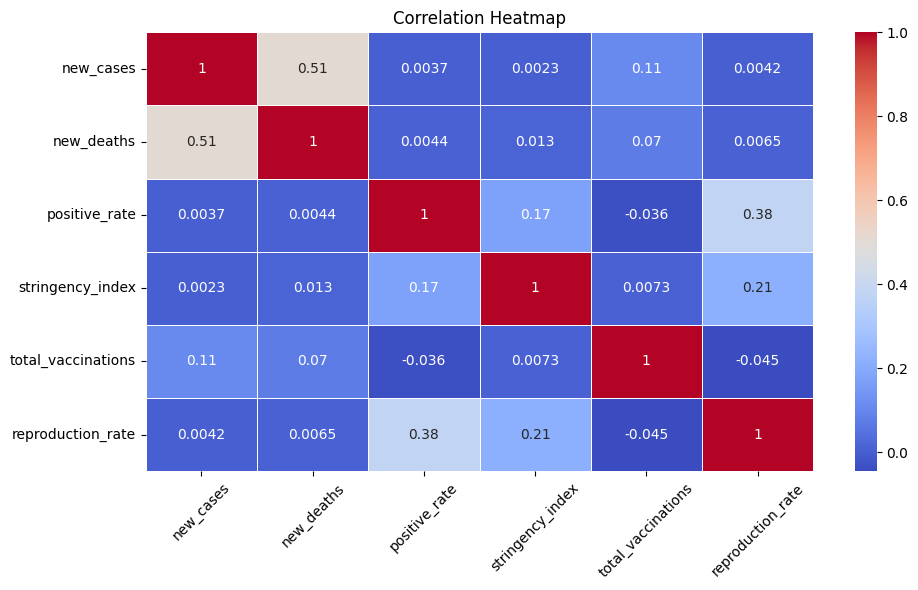

In [24]:
plt.figure(figsize=(10, 6))
corr = pandas_df.corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [1]:
#-----  Finding Hugh Risk Days in regards to new cases smoothed per million plus new deaths smoothed per million -------


In [34]:
from pyspark.sql.functions import col, when

# Step 1: Calculate quantiles
q_low_cases, q_high_cases = df.approxQuantile("new_cases_smoothed_per_million", [0.3, 0.7], 0.01)
q_low_deaths, q_high_deaths = df.approxQuantile("new_deaths_smoothed_per_million", [0.3, 0.7], 0.01)

# Step 2: Infection risk based on quantiles
df = df.withColumn(
    "infection_risk_level",
    when(col("new_cases_smoothed_per_million") <= q_low_cases, "Low")
    .when((col("new_cases_smoothed_per_million") > q_low_cases) &
          (col("new_cases_smoothed_per_million") <= q_high_cases), "Medium")
    .otherwise("High")
)

# Step 3: Death risk based on quantiles
df = df.withColumn(
    "death_risk_level",
    when(col("new_deaths_smoothed_per_million") <= q_low_deaths, "Low")
    .when((col("new_deaths_smoothed_per_million") > q_low_deaths) &
          (col("new_deaths_smoothed_per_million") <= q_high_deaths), "Medium")
    .otherwise("High")
)

# Step 4: Final combined overall risk label
df = df.withColumn(
    "overall_risk_level",
    when((col("infection_risk_level") == "High") | (col("death_risk_level") == "High"), "High")
    .when((col("infection_risk_level") == "Medium") | (col("death_risk_level") == "Medium"), "Medium")
    .otherwise("Low")
)

# Step 5: View final class distribution
df.groupBy("overall_risk_level").count().orderBy("overall_risk_level").show()


+------------------+------+
|overall_risk_level| count|
+------------------+------+
|              High|160735|
|               Low|136444|
|            Medium|132256|
+------------------+------+



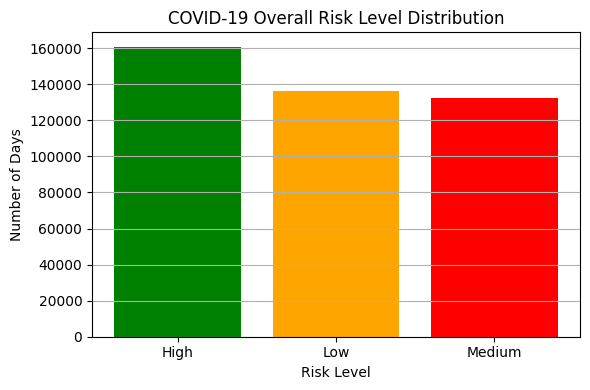

In [35]:
# Convert to Pandas for plotting
risk_dist_pd = df.groupBy("overall_risk_level").count().orderBy("overall_risk_level").toPandas()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(risk_dist_pd["overall_risk_level"], risk_dist_pd["count"], color=["green", "orange", "red"])
plt.title("COVID-19 Overall Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Number of Days")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [36]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Step 1: Index target column
label_indexer = StringIndexer(inputCol="overall_risk_level", outputCol="label")

# Step 2: Feature selection (example set — tune this!)
feature_cols = ["stringency_index", "reproduction_rate", "population_density", "gdp_per_capita", "diabetes_prevalence"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Step 3: Select model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

# Step 4: Pipeline
pipeline = Pipeline(stages=[label_indexer, assembler, rf])

# Step 5: Train/Validation Split
train_data, val_data = df.randomSplit([0.8, 0.2], seed=42)

# Step 6: Hyperparameter Tuning (Grid Search)
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.numTrees, [20, 50]) \
    .build()

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                    numFolds=3)

# Step 7: Train model
cv_model = cv.fit(train_data)


Model Selection

In [37]:
# Predict on validation set
predictions = cv_model.transform(val_data)

# Evaluate performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
print("Accuracy:", evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("F1 Score:", evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print("Precision:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}))
print("Recall:", evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))


Accuracy: 0.7260600285850405
F1 Score: 0.7238039800672433
Precision: 0.7382930733674551
Recall: 0.7260600285850405
